In [14]:
import pandas as pd 
import numpy as np 
import pickle
import os 
from scipy.stats import norm
os.chdir(r'C:\Users\User\Desktop\Optimization\Algorithms\Genetic Algorithm')
from ga import *
os.chdir(r'C:\Users\User\Desktop\Optimization\Algorithms\Bayesian MCMC')
from BayesianOptimizer import *
import time
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt


In [42]:
def obj(percentage_miss_strength):
    obj_func = []
    for i in percentage_miss_strength:
        # Compute objective function value
        obj_func.append(regional_obj_fatality(i))
    return np.array(obj_func)

def total_strength(percentage_miss_strength, sampled_building_info, Sa_map, miss_strength, IM_bin):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    cost_map = pd.DataFrame(np.zeros(Sa_map.shape))
    for k in range(8):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Total Force'] = np.multiply(percentage_miss_strength[k], miss_strength['X Diff']) + np.multiply(percentage_miss_strength[k], miss_strength['Z Diff'])
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_cost = sub_building_map.merge(temp)
            cost_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = building_cost.iloc[:,1]

    total_cost =  cost_map.mean(axis = 1).sum()
    return total_cost

def summary_fatality(percentage_miss_strength):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    im_bin = [0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength'])
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength'])
        temp = pd.concat([temp,retrof_upper_limit]).min(level=0)
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    region_fatality = compute_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)
    individual_fatality = compute_individual_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)
    return region_fatality, individual_fatality

def regional_obj_fatality(percentage_miss_strength):
    '''
    This function is developed for compute objective function corresponding to single set of value
    '''
    im_bin = [0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength'])
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength'])
        temp = pd.concat([temp,retrof_upper_limit]).min(level=0)
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    region_fatality = compute_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)

    # Compute penalty term
    region_penalty = penalty(sampled_building_info, percentage_miss_strength, w, pd.DataFrame(index=[1,2,3,4,5,6,7,8]), retrof_percent_range, 'inverse')
    return -region_fatality - region_penalty


def compute_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    IM_bin: different retrofit strength is applied to different intensity bins
    '''

    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(total_fatality)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(8):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1])
            ds_prob_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1]).sum().sum()
    return portfolio_fatality


def compute_individual_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(total_fatality)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(8):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j]
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1])
            ds_prob_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    individual_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1])

    return individual_fatality

def penalty(sampled_building_info, ratios, w, penalty_df, retrof_limit, penalty_type):

    if penalty_type == 'linear':
        penalty_df['penalty'] = np.multiply(w , np.sqrt(ratios**2)) # In this case, w is a 4x1 list 

    elif penalty_type == 'inverse':
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = temp**2 # In this case, w is a single number

    elif penalty_type == 'quadratic-inverse':
        temp = np.divide(w, np.multiply(ratios-retrof_limit[0]+0.0000001,retrof_limit[1]-ratios+0.0000001))
        penalty_df['penalty'] = temp # In this case, w is a single number
 
    return penalty_df['penalty'].sum()


def ordinance_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(building_fatality)

    # Building damage state median at each location 
    building_ds_median = buildings.merge(building_dsm)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))
    # Loop over all shake maps
    for j in range(Sa_map.shape[1]):
        ds_prob_map.iloc[:,j] = norm.cdf(np.log(Sa_map.iloc[:,j]), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1]).sum().sum()
    
    return portfolio_fatality

In [16]:
# Load ML prediction models 
# os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Existing')
# existing_slight = pickle.load(open('Slight.pickle','rb'))
# existing_moderate = pickle.load(open('Moderate.pickle','rb'))
# existing_severe = pickle.load(open('Severe.pickle','rb'))
# existing_complete = pickle.load(open('Complete.pickle','rb'))

os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Retrofit')
# retrof_slight_ratio = pickle.load(open('Retrof_Slight_Ratio.pkl','rb'))
# retrof_moderate_ratio = pickle.load(open('Retrof_Moderate_Ratio.pkl','rb'))
# retrof_severe_ratio = pickle.load(open('Retrof_Severe_Ratio.pkl','rb'))
retrof_complete_ratio = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

[22:42:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
# Sample unknown buildings 
def samplecase(OriginalData):
    InventoryData = OriginalData
    InventoryData = InventoryData.drop(columns = ['SMS'])
    for i in range(InventoryData.shape[0]):
        # Randomly assign number of stories
        if np.isnan(InventoryData.iloc[i,2]):
            InventoryData.iloc[i,2] = np.random.choice(np.arange(2, 4), p=[0.759, 0.241])
            
        # Randomly assign floor type          
        if pd.isnull(InventoryData.iloc[i,3]):
            InventoryData.iloc[i,3] = np.random.choice(np.arange(1, 5), p=[0.159, 0.011, 0.458, 0.372])
            
    
    
    InventoryData.loc[InventoryData['Story'] == 2,'Story'] = "2"
    InventoryData.loc[InventoryData['Story'] == 3,'Story'] = "3"
    
    InventoryData.loc[InventoryData['Type'] == 1,'Type'] = 'FWL1'
    InventoryData.loc[InventoryData['Type'] == 2,'Type'] = 'FWL2'
    InventoryData.loc[InventoryData['Type'] == 3,'Type'] = 'FWL3'
    InventoryData.loc[InventoryData['Type'] == 4,'Type'] = 'FWL4'
    
    InventoryData.loc[InventoryData['Type'] == 'FWL1','Type'] = 'L1'
    InventoryData.loc[InventoryData['Type'] == 'FWL2','Type'] = 'L2'
    InventoryData.loc[InventoryData['Type'] == 'FWL3','Type'] = 'L3'
    InventoryData.loc[InventoryData['Type'] == 'FWL4','Type'] = 'L4'
    
#     Randomly assign material type 
    mat = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Material'] = mat
    
    InventoryData.loc[InventoryData['Material'] == 1,'Material'] = 'GWB'
    InventoryData.loc[InventoryData['Material'] == 2,'Material'] = 'HWS'
    
#     Randomly assign dimension 
    dim = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Dimension'] = dim
    
#     Assign floor type
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X30'
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 1),'Dimension'] = '50X30'
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 2),'Dimension'] = '80X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 50*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 50*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 80*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 80*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3

    InventoryData['Index'] = InventoryData['Type'] + '-' + InventoryData['Story'] + 'S-' + InventoryData['Dimension'].astype('str') + '-' + InventoryData['Material']
    
    #     Randomly assign repair cost
    InventoryData['Num_Units'] = (np.round(InventoryData['Area'].values/1000)).astype(int)
    Median_Cost = np.interp(InventoryData['Num_Units'],[4,30],[6250,4000])
    
    InventoryData['RepairCost'] = np.random.normal(Median_Cost,400)*InventoryData['Num_Units']
    
    return InventoryData

In [18]:
os.chdir(r'C:\Users\User\Desktop\Optimization\Fatality')
OriginalBuildingInfo = pd.read_csv('LA Inventory.csv')

# Random assign unknown buildings
sampled_building_info = samplecase(OriginalBuildingInfo)

# Optimize for the M7.1 senario
sa_simulated = pd.read_csv('PuenteHillResults\Sa_simulated_real.csv', header = None)

# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('building_performance.csv')

# Read building configuration, which is mainly used for loss assessment 
building_config = pd.read_csv('building_configuration.csv')

# Read building losses
total_loss = pd.read_csv('ds_loss.csv')

# Read building fatality 
total_fatality = pd.read_csv('fatality_rate.csv')

# Read retrofit upper limit, which corresponding to NON SWOF building peak strength
retrof_upper_limit = pd.read_csv('UpperLimit.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

# Read existing building damage state medians
existing_ds = pd.read_csv('building_ds.csv')

# Existing pushover peak strength
peak_strength = pd.DataFrame()
peak_strength['Index'] = existing_prop['Index']
peak_strength['Xpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Xpeakstrength'])
peak_strength['Zpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Zpeakstrength'])

## Fatality Optimization

In [19]:
from bayes_opt import BayesianOptimization

def obj_func(a,b,c,d,e,f,g,h):
    p = [a,b,c,d,e,f,g,h]
    return regional_obj_fatality(p)
retrof_percent_range = np.array([[0]*8, [1]*8])
pbounds = {'a':(0, 1), 'b':(0, 1), 'c':(0, 1), 'd':(0, 1), 'e':(0, 1), 'f':(0, 1), 'g':(0, 1), 'h':(0, 1)}

In [21]:
W = [0, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2]
x_best  = []
for w in W:
    optimizer = BayesianOptimization(f = obj_func,
                                    pbounds = pbounds)
    optimizer.maximize(init_points = 200, n_iter = 150)
    x_best.append(optimizer.max['params'])

48    |  0.47     |  0.526    |  0.05685  |
|  253      | -199.1    |  0.1092   |  0.0231   |  0.6164   |  0.322    |  0.6836   |  0.09591  |  0.2909   |  0.06204  |
|  254      | -199.4    |  0.05433  |  0.1698   |  0.1281   |  0.3161   |  0.2891   |  0.3451   |  0.3355   |  0.1464   |
|  255      | -199.4    |  0.05547  |  0.1681   |  0.1204   |  0.3156   |  0.2858   |  0.3466   |  0.3396   |  0.1468   |
|  256      | -199.4    |  0.2742   |  0.1866   |  0.2369   |  0.2635   |  0.3512   |  0.4713   |  0.523    |  0.05741  |
|  257      | -199.4    |  0.27     |  0.181    |  0.2385   |  0.2629   |  0.3485   |  0.4704   |  0.525    |  0.05424  |
|  258      | -199.1    |  0.1099   |  0.0211   |  0.615    |  0.3202   |  0.6841   |  0.09502  |  0.2921   |  0.06471  |
|  259      | -199.1    |  0.1095   |  0.02213  |  0.6157   |  0.3211   |  0.6839   |  0.0955   |  0.2915   |  0.06325  |
|  260      | -199.4    |  0.05585  |  0.1699   |  0.1209   |  0.3151   |  0.2848   |  0.3476   |  0.3

## Post Processing

In [52]:
total_fatality_algorithm = []
total_cost = []
im_bin = [0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, float('inf')]

for x in x_best:
    a, b = summary_fatality(list(x.values()))
    total_fatality_algorithm.append(a)
    total_cost.append(total_strength(list(x.values()), sampled_building_info, sa_simulated, missing_strength, im_bin))



In [61]:
ordinance_ds = pd.read_csv(r'C:\Users\User\Desktop\Optimization\Fatality\ordinance_building_ds.csv')
ordinance_ds = ordinance_ds.drop(columns=['Slight', 'Moderate', 'Severe'])
of = ordinance_fatality(sampled_building_info, total_fatality, ordinance_ds, sa_simulated)
ef = ordinance_fatality(sampled_building_info, total_fatality, existing_ds.drop(columns=['Slight', 'Moderate', 'Severe']), sa_simulated)
ordinance_strength = pd.read_csv(r'C:\Users\User\Desktop\Optimization\Fatality\ordinance_inc_strength.csv')
merged_info = sampled_building_info.merge(ordinance_strength, left_on='Index', right_on='Index')
oc = merged_info['X Inc Force'].sum() + merged_info['Z Inc Force'].sum()
ordinance_reduction = 1 - of/ef
algorithm_reduction = [1-x/ef for x in total_fatality_algorithm]

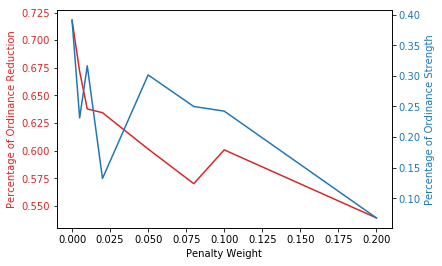

In [70]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Penalty Weight')
ax1.set_ylabel('Percentage of Ordinance Reduction', color=color)
ax1.plot(W, np.divide(algorithm_reduction, ordinance_reduction), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Percentage of Ordinance Strength', color=color)  # we already handled the x-label with ax1
ax2.plot(W, np.divide(total_cost, oc), color=color)
ax2.tick_params(axis='y', labelcolor=color)

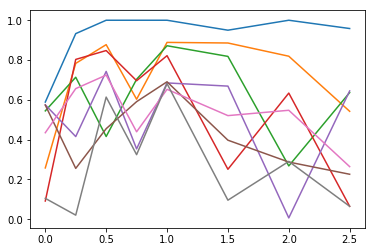

In [74]:
for x in x_best:
    plt.plot([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5], list(x.values()))